## Importing Libraries

In [1136]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import plotly.express as px
import numpy as np
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot as plt
import seaborn as sns


## Loading the Data

In [1137]:
df = pd.read_csv("Breast_Cancer.csv", header=0, delimiter=',')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


## Dataset Inspection

In [1138]:
numerical_cols = ['Age','Tumor Size','Regional Node Examined','Reginol Node Positive','Survival Months']
categorical_cols = ['Race','Marital Status','T Stage ','N Stage','6th Stage','differentiate','Grade','A Stage','Estrogen Status','Progesterone Status']

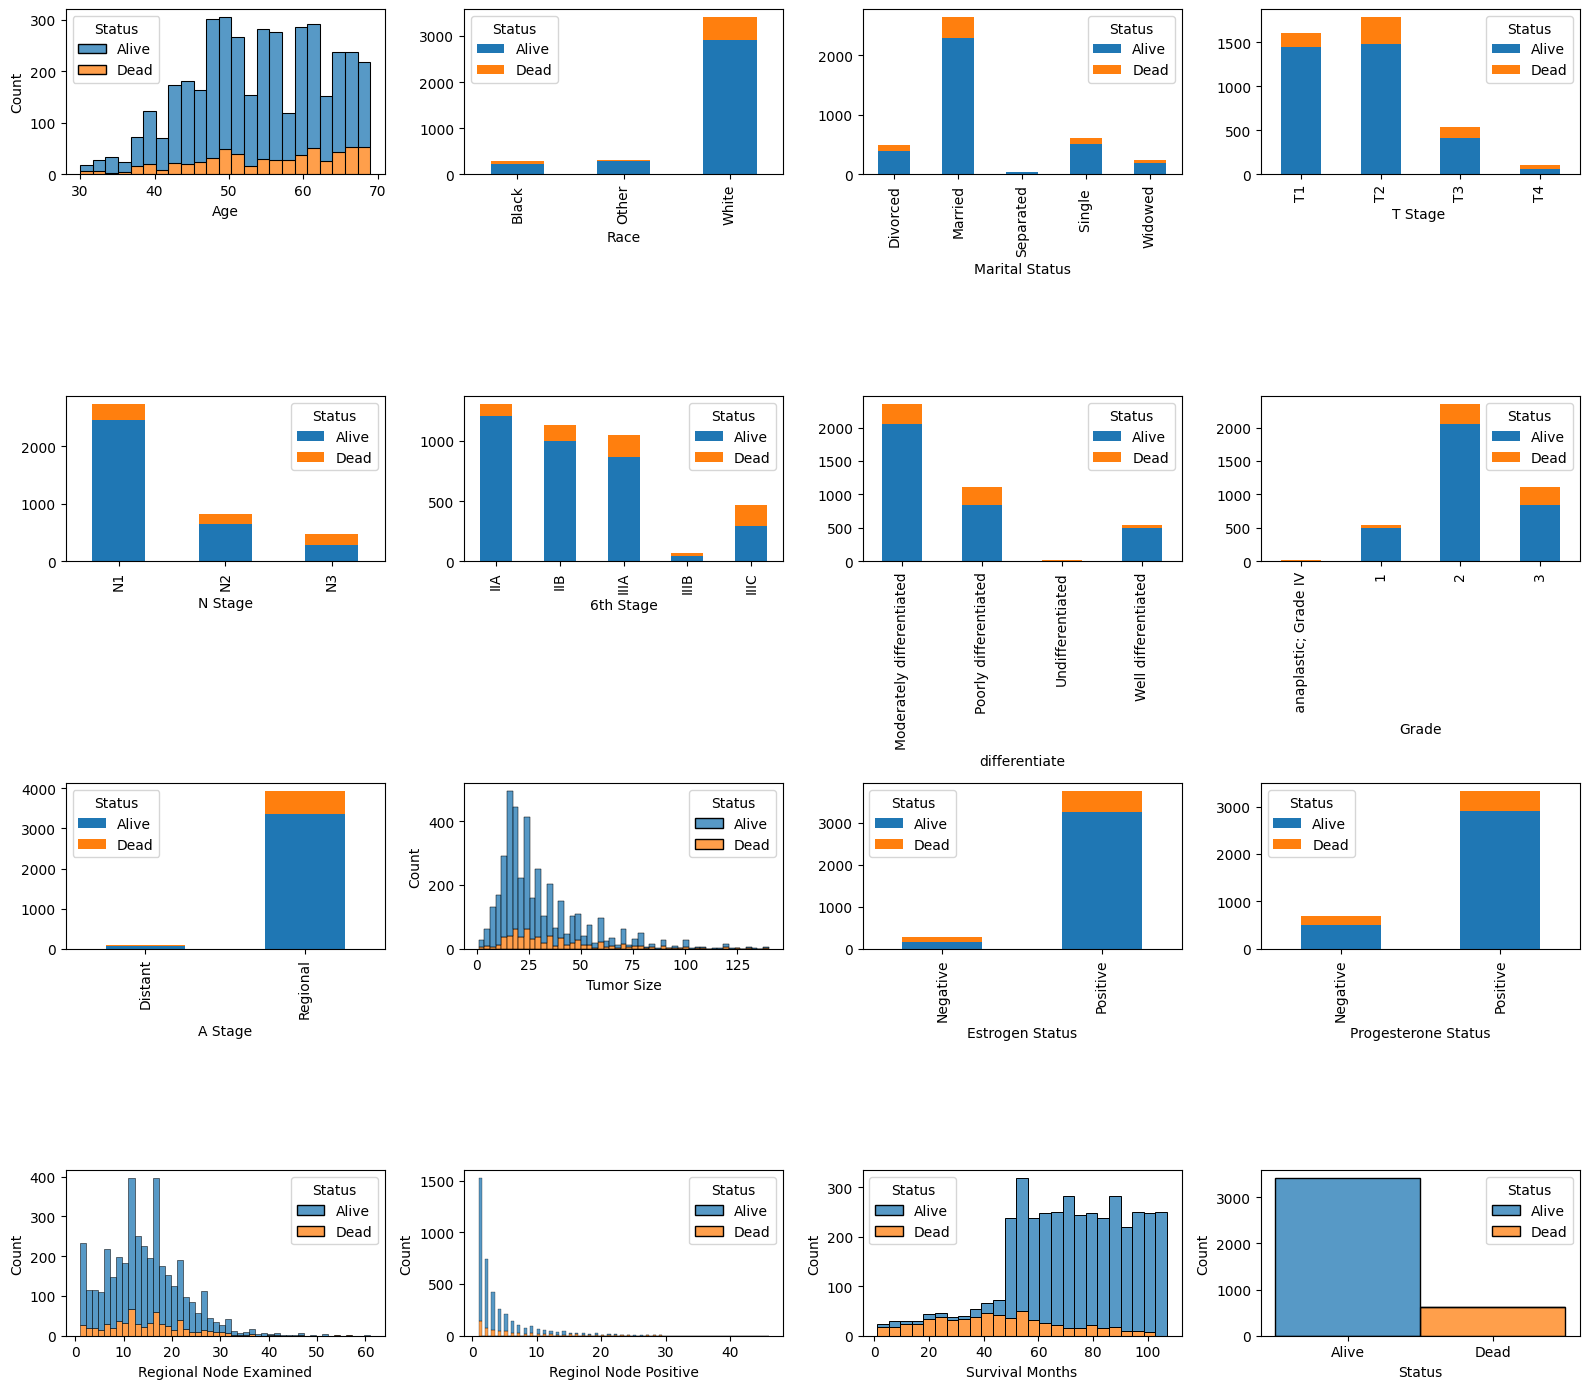

In [1139]:
fig, axes = plt.subplots(4,4,figsize=(16,14))

for i, c in enumerate(df.columns):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        ct = pd.crosstab(index=df[c], columns=df['Status'])
        a = ct.plot(kind='bar', stacked=True,ax=ax)
    else: 
        sns.histplot(x=c,data=df, hue='Status',ax=ax, multiple='stack')
plt.tight_layout()

## Train Test Split

In [1140]:
X = df.loc[:,df.columns != 'Status']
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


## Preprocessing

In [1141]:
def preprocessing(X, y, scaler=None):
    # We scale all the columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X[numerical_cols] = scaler.transform(X[numerical_cols])
    # One Hot Encoding
    X = pd.get_dummies(X, columns = categorical_cols)
    # Encode output
    status_map = {'Dead': 1, 'Alive': 0}
    y = y.map(status_map)
    y = y.rename('Dead')
    return X, y, scaler

X_train, y_train, scaler = preprocessing(X_train,y_train)
X_val, y_val, _ = preprocessing(X_val, y_val, scaler)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)

## Outlier Detection

In [1142]:
# Outlier detection
joined = X_train.join(y_train)
local_outlier_factor = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
result = local_outlier_factor.fit_predict(joined[numerical_cols])
no_outliers = result == 1
joined = joined[no_outliers]
y_train = joined.pop('Dead')
X_train = joined

## Data Balancing

In [1143]:
print('Original dataset shape:', Counter(y_train))

Original dataset shape: Counter({0: 2096, 1: 350})


In [1144]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN for combined oversampling and undersampling
smote_enn = SMOTEENN(sampling_strategy='minority')
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print('Resampled dataset shape:', Counter(y_train))


Resampled dataset shape: Counter({1: 1692, 0: 1386})


## Support Functions

In [1145]:
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

In [1146]:
def compute_metrics(y_real,y_pred):
    accuracy = accuracy_score(y_real, y_pred)
    f1 =f1_score(y_real,y_pred, pos_label=1)
    precision = precision_score(y_real, y_pred, pos_label=1)
    recall =recall_score(y_real,y_pred, pos_label=1)
    jaccard = jaccard_score(y_real, y_pred, pos_label=1)
    return [accuracy, f1, precision, recall, jaccard]

## LDA

In [1147]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)
results_df.loc['LDA',:] = compute_metrics(y_val, y_pred_lda)
results_df

,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.838509,0.559322,0.481752,0.666667,0.388235


In [1148]:
# Exploring LDA
X_transformed = lda_model.transform(X_train)

X_transformed = pd.DataFrame(X_transformed)
X_transformed['labels'] = y_train.reset_index(drop=True)
X_transformed

,0,labels
0,-1.833737,0
1,-0.516530,0
2,-2.441241,0
3,-0.734288,0
4,-1.425753,0
...,...,...
3073,0.973216,1
3074,-0.689337,1
3075,3.683869,1
3076,1.043712,1


<Axes: xlabel='0'>

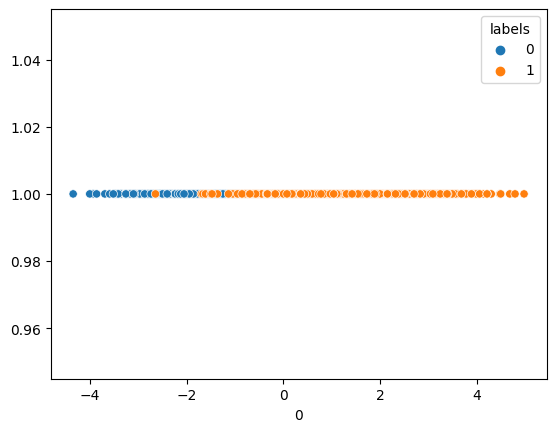

In [1149]:
sns.scatterplot(x= 0, y= 1, data = X_transformed, hue='labels')

## KNN

In [1150]:
from sklearn.neighbors import KNeighborsClassifier


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'))
results_knn = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

k_values = range(1,50,2)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn = knn.fit(X_train,y_train)
    y_pred = knn.predict(X_val)
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred)

sorted_results_knn = results_knn.sort_values(by='Recall', ascending=False)
print(sorted_results_knn)

          Accuracy        F1 Precision    Recall   Jaccard
model k                                                   
KNN   27  0.687888  0.424069     0.296  0.747475  0.269091
      15  0.701863  0.435294  0.307054  0.747475  0.278195
      21  0.690994  0.426513  0.298387  0.747475  0.271062
      25  0.684783  0.418338     0.292  0.737374  0.264493
      5   0.718944  0.446483  0.320175  0.737374  0.287402
      7   0.712733  0.441088  0.314655  0.737374  0.282946
      9   0.709627  0.438438  0.311966  0.737374  0.280769
      11  0.700311  0.430678  0.304167  0.737374  0.274436
      13  0.701863  0.431953  0.305439  0.737374  0.275472
      19  0.692547  0.424419  0.297959  0.737374  0.269373
      23  0.687888  0.420749  0.294355  0.737374  0.266423
      31  0.681677  0.412607     0.288  0.727273  0.259928
      29  0.673913   0.40678  0.282353  0.727273  0.255319
      49  0.645963  0.387097  0.263736  0.727273      0.24
      17  0.704969  0.427711  0.304721  0.717172  0.2720

In [1151]:

# Retrieve the k value of the first row
first_row = sorted_results_knn.iloc[0]
k_value = first_row.name[1]

print("k value of the first row:", k_value)

knn = KNeighborsClassifier(n_neighbors=k_value)
knn = knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_val)
results_df.loc['KNN-'+str(k_value), :] = compute_metrics(y_val, y_pred_knn)
results_df

k value of the first row: 27


,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.838509,0.559322,0.481752,0.666667,0.388235
KNN-27,0.687888,0.424069,0.296,0.747475,0.269091


## Logistic Regression

In [1152]:
from sklearn.linear_model import LogisticRegression


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'))
results_logreg = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C, max_iter=1000)
    logreg = logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_val)
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred)

sorted_results_logreg = results_logreg.sort_values(by='Recall', ascending=False)
print(sorted_results_logreg)

                 Accuracy        F1 Precision    Recall   Jaccard
model  C                                                         
LogReg 0.1       0.756211  0.501587  0.365741   0.79798  0.334746
       1.0       0.798137  0.525547  0.411429  0.727273  0.356436
       100000.0  0.807453  0.515625  0.420382  0.666667  0.347368
       1000.0    0.807453  0.515625  0.420382  0.666667  0.347368
       10000.0   0.805901  0.509804  0.416667  0.656566  0.342105
       100.0     0.804348  0.507812  0.414013  0.656566  0.340314
       10.0      0.796584  0.498084  0.401235  0.656566  0.331633


In [1153]:
# Retrieve the k value of the first row
first_row = sorted_results_logreg.iloc[0]
c_value = first_row.name[1]

print("c value of the first row:", c_value)

logreg = LogisticRegression(C=c_value, max_iter=1000).fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_val)
results_df.loc['LogReg-'+str(c_value), :] = compute_metrics(y_val, y_pred_logreg)

results_df.sort_values(by='Recall', ascending=False)

c value of the first row: 0.1


,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.756211,0.501587,0.365741,0.79798,0.334746
KNN-27,0.687888,0.424069,0.296,0.747475,0.269091
LDA,0.838509,0.559322,0.481752,0.666667,0.388235


## Random Forest

In [1154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]   # Minimum number of samples required to split an internal node
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring='recall',
                           cv=5,
                           refit='recall')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Print the best score found by GridSearchCV
print("Best Score:", grid_search.best_score_)

# Get the best model found by GridSearchCV
best_rfmodel = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9793004136775408


In [1155]:
y_pred_rf = best_rfmodel.predict(X_val)
results_df.loc['Random Forest', :] = compute_metrics(y_val, y_pred_rf)

results_df.sort_values(by='Recall', ascending=False)

,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.756211,0.501587,0.365741,0.79798,0.334746
KNN-27,0.687888,0.424069,0.296,0.747475,0.269091
Random Forest,0.807453,0.526718,0.423313,0.69697,0.357513
LDA,0.838509,0.559322,0.481752,0.666667,0.388235


## Feature Importance

<Axes: >

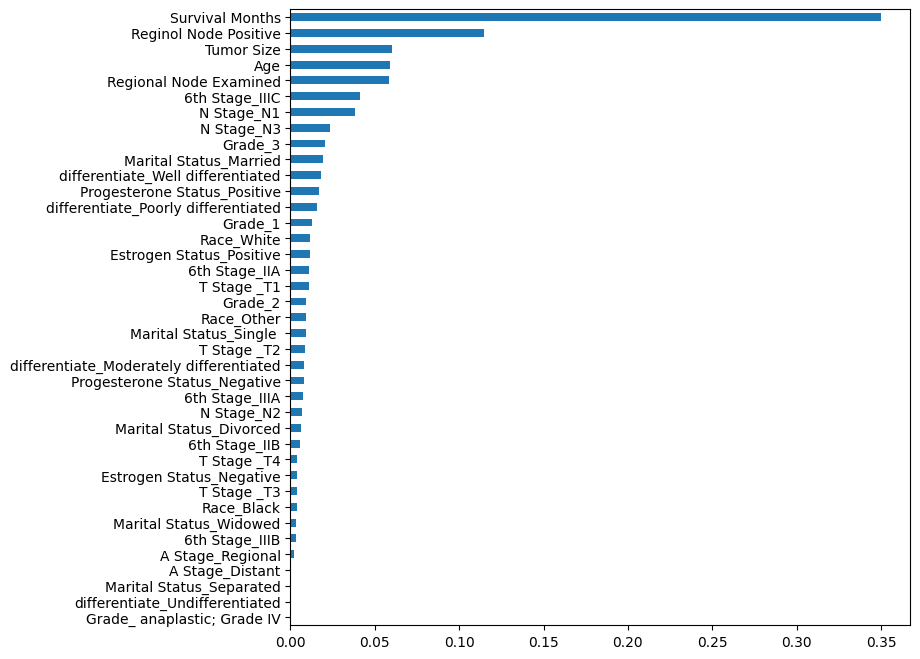

In [1156]:
var_imp = pd.DataFrame({'importance': best_rfmodel.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False)

## Generalization Performance

In [1157]:
logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg = logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

In [1158]:
print('accuracy_score: ',accuracy_score(y_test,y_pred))
print('recall_score: ',recall_score(y_test,y_pred))
print('jaccard_score: ',jaccard_score(y_test,y_pred))
print('f1_score: ',f1_score(y_test,y_pred))
print('precision_score: ',precision_score(y_test,y_pred))

fig = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),2), 
                template='ggplot2',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")
fig.show()

accuracy_score:  0.746583850931677
recall_score:  0.7560975609756098
jaccard_score:  0.31313131313131315
f1_score:  0.4769230769230769
precision_score:  0.34831460674157305
